In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

# Actividad 1. Detección de giro

In [2]:
video = cv.VideoCapture("videos/carretera_nueva.mp4")
i = 0
while(video.isOpened() and i < 1):
    ret, frame = video.read()
    if ret == False:
        break
    cv.imwrite('figuras/imagen1_' + str(i) + '.jpg', frame)
    i += 1
video.release()
cv.destroyAllWindows()

In [3]:
def binarizacion(imagen):
    img = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gauss = cv.GaussianBlur(img_gray, (3, 3), 0)
    thr, img_thr = cv.threshold(img_gauss, 160, 255, cv.THRESH_BINARY)
    alto = img.shape[0]
    ancho = img.shape[1]
    ratio = 0.2
    img_r = cv.resize(img_thr, (480, 240), interpolation = cv.INTER_NEAREST)
    return(img_r)

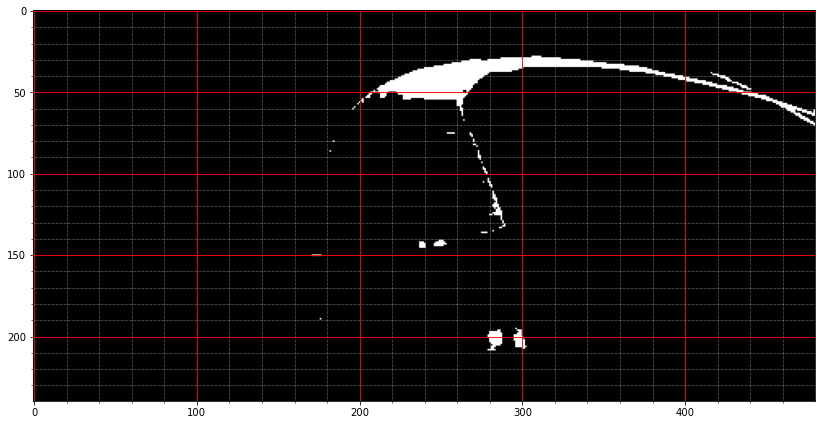

In [4]:
#probar la binarizacion en una imagen del video
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
fig, ax = plt.subplots(figsize = (14, 14))
ax.imshow(img_bin, cmap = 'gray')
ax.minorticks_on()
ax.grid(which = 'major', linestyle = '-', linewidth = '0.9', color = 'red')
ax.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'white')

In [10]:
#Poligono de área de interés
x1 = (200, 40)
x2 = (280, 40)
x3 = (190, 50)
x4 = (290, 50)

pts_poligono = np.array([x1, x2, x3, x4], np.int32)
pts_poligono = pts_poligono.reshape((-1, 1, 2))

In [11]:
#Funcion de área de interés
def area_interes(imagen):
    pts1 = np.float32([x1, x2, x3, x4])
    pts2 = np.float32([[0, 0], [480, 0], [0, 240], [480, 240]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    img_warp = cv.warpPerspective(imagen, matrix, (480, 240))
    return (img_warp)

In [12]:
#Función para encontrar el punto medio
def punto_medio(imagen):
    img_cercana = imagen[220:, :]
    suma_columnas = img_cercana.sum(axis = 0)
    x_pos = np.arange(len(suma_columnas))
    mid_point = int(np.dot(x_pos, suma_columnas) / np.sum(suma_columnas))
    return mid_point

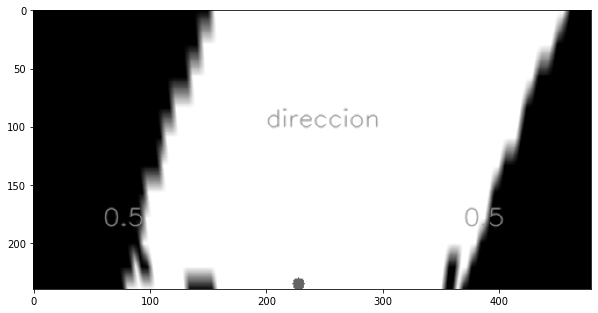

In [13]:
#Aplicamos todas las funciones
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
img_interes = area_interes(img_bin)
mid_point = punto_medio(img_interes)

#textos
text1 = str(0.50)
text2 = str(0.50)
text3 = 'direccion'

#agregamos el tipo de fuente
font = cv.FONT_HERSHEY_SIMPLEX

#origen de cada texto
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

#tamaño 
fontScale = 0.7

#color de la fuente
color = (150, 150, 150)

#grosor
thickness = 1

#usamos la funcion 'cv.putText()' que permitirá agregar texto
cv.putText(img_interes, text1, org1, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text2, org2, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text3, org3, font, fontScale,
              color, thickness, cv.LINE_AA, False)

plt.figure(figsize = (10, 7))
cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
plt.imshow(img_interes, cmap = 'gray')
plt.show()

In [14]:
#Funcion suma normalizada izquierda
def sum_izquierda(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, :valor_punto_medio].sum(axis=0))/(255*240*480), 2)

In [15]:
#Funcion suma normalizada derecha
def sum_derecha(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, valor_punto_medio:].sum(axis=0))/(255*240*480), 2)

In [16]:
sum_izquierda(img_interes, mid_point)

0.23

In [17]:
sum_derecha(img_interes, mid_point)

0.38

In [23]:
#Implementacion de la dirección de giro en el video 

video = cv.VideoCapture('videos/carretera_nueva.mp4')
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("video", frame)
        
        img_bin = binarizacion(frame)
        
        cv.polylines(img_bin, [pts_poligono], True, (100, 100, 100))
        
        img_interes = area_interes(img_bin)
        
        mid_point = punto_medio(img_interes)
        
        valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
        valor_sum_derecha = sum_derecha(img_interes, mid_point)
        
        cv.putText(img_interes, str(valor_sum_izquierda), org1, font, fontScale,
                   color, thickness, cv.LINE_AA, False)
        cv.putText(img_interes, str(valor_sum_derecha), org2, font, fontScale,
                   color, thickness, cv.LINE_AA, False)
        
        delta = valor_sum_izquierda - valor_sum_derecha
        
        if delta > 0.07:
            movimiento = "izquierda"
        elif delta < -0.07:
            movimiento = "derecha"
        else:
            movimiento = "adelante"
            
        cv.putText(img_interes, movimiento, org3, font, fontScale,
                  color, thickness, cv.LINE_AA, False)
        cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
        cv.imshow("video area interes", img_interes)
        
        time.sleep(0.02)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()